In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from tqdm import tqdm

font = {'family': 'normal',
        'weight': 'bold',
        'size': 22}

matplotlib.rc('font', **font)

from astropy.io import fits
from astropy.table import Table
from astropy import units as u
from astropy.io import ascii
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz

from dustmaps.bayestar import BayestarWebQuery
from whampy.skySurvey import SkySurvey

from astro import distance
from lvmsurveysim.utils import shadow_height_lib as sh
from lvmdrp.core import sky


from skyfield.api import load
from skyfield.framelib import ecliptic_frame
from skyfield.positionlib import ICRS


def moon_phase(jd, ephemeris):
    """Returns lunation for a given ephemeris and JD
    
    NOTES: original source from https://bit.ly/3VppeZo
    """

    ts = load.timescale()
    t = ts.tt_jd(jd)

    sun, moon, earth = ephemeris['sun'], ephemeris['moon'], ephemeris['earth']

    e = earth.at(t)
    s = e.observe(sun).apparent()
    m = e.observe(moon).apparent()

    _, slon, _ = s.frame_latlon(ecliptic_frame)
    _, mlon, _ = m.frame_latlon(ecliptic_frame)
    phase = (mlon.degrees - slon.degrees) % 360.0

    return m.fraction_illuminated(sun)


def moon_separation(jd, ephemeris, ra, dec):
    """Returns moon separation from given target"""
    
    e = ephemeris["earth"].at(load.timescale().tt_jd(obs["JD"]))

    dk = ICRS.from_radec(ra, dec)

    om = e.observe(ephemeris["moon"])
    ra, dec, _ = om.radec()
    sep = dk.separation_from(ICRS.from_radec(ra_hours=ra.hours, dec_degrees=dec.degrees)).degrees

    return sep

In [2]:
# read dark patches table
darks = ascii.read('_data-sky/darks.txt')
darks.sort(keys="ra")
darks.info()

new_darks = ascii.read("_data-sky/EP_dobashi2011_nobrights.txt")

new_darks.rename_columns(names=["Dobashi2011_ID", "ra(J2000)", "dec(J2000)"], new_names=["ID", "ra", "dec"])
new_darks.sort(keys="ra")
new_darks["i"] = np.arange(len(new_darks))
new_darks.info()

<Table length=675>
 name  dtype 
----- -------
    i   int64
   ra float64
  dec float64
    l float64
    b float64
IMW80 float64
IMW40 float64
<Table length=132>
name  dtype 
---- -------
  ID float64
  ra float64
 dec float64
   i   int64


In [3]:
# read survey tables
lvm = ascii.read('_data-sky/survey.txt')
lvm.add_column(np.arctan(lvm["lunation"])*180/np.pi, name="moon_sun_sep")
lvm = lvm[lvm['ra']!=-999.0]
lvm.info()

<Table length=24758>
     name      dtype 
------------- -------
           JD float64
  observatory    str3
       target   str12
        group    str6
       tileid   int64
        index   int64
           ra float64
          dec float64
           pa float64
      airmass float64
     lunation float64
shadow_height float64
    moon_dist float64
          lst float64
      exptime float64
    totaltime float64
 moon_sun_sep float64


Text(0, 0.5, 'EBV (mag)')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


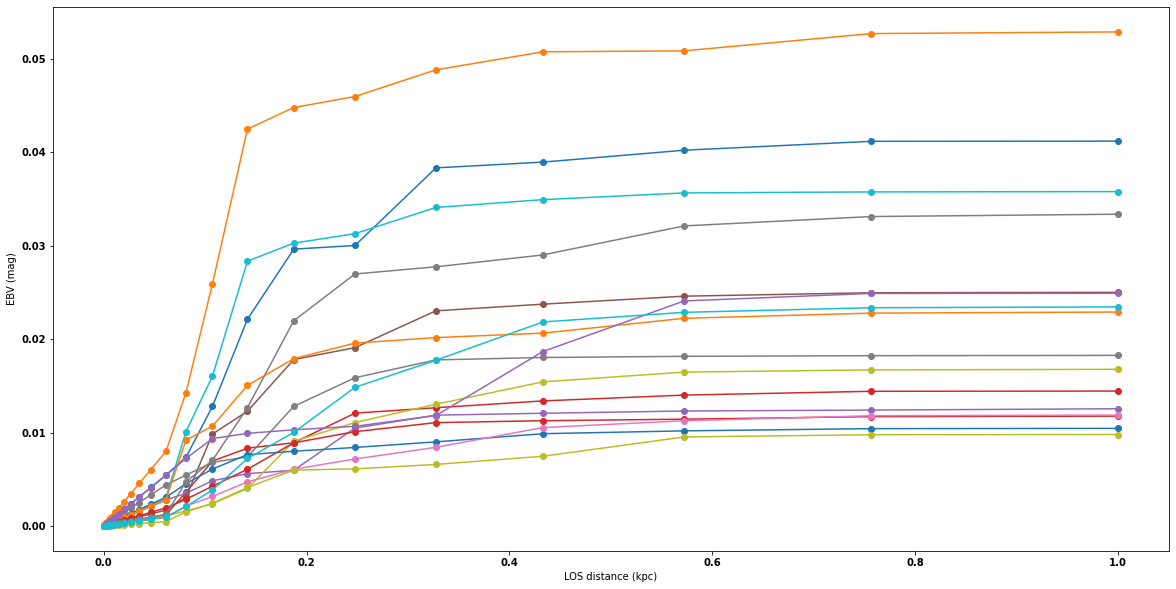

In [4]:
bst = BayestarWebQuery(version="bayestar2015")
dist = np.logspace(np.log10(1e-12), np.log10(1), 100)
# plt.plot(dist, np.zeros_like(dist), "ok")

plt.figure(figsize=(20,10))
for idx, row in darks.to_pandas().head(20).iterrows():
    ebv = bst(SkyCoord(
        ra=row["ra"]*u.deg,
        dec=row["dec"]*u.deg,
        distance=dist*u.kpc,
    ), mode="median")

    plt.plot(dist, ebv, "o-")

plt.xlabel("LOS distance (kpc)")
plt.ylabel("EBV (mag)")
# use SK law to estimate a first order Halpha

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


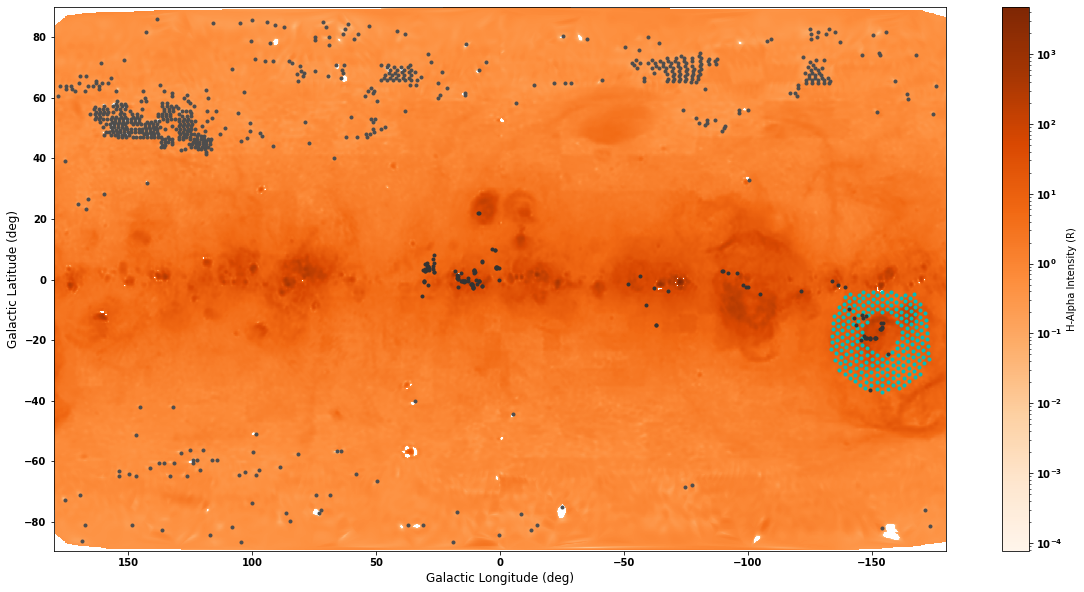

In [5]:
# u.add_enabled_units({"DEG": u.deg})

# Load Survey
wham = SkySurvey()
# Quick Sky Map
fig = wham.intensity_map(smooth=True, colorbar=True, cmap="Oranges", vmin=None, vmax=None, fig=plt.figure(figsize=(20,10)))
ax = plt.gca()

survey = lvm[lvm["target"] == "ORION_SPARSE"]

dark_coords = SkyCoord(darks["ra"], darks["dec"], unit="deg")
dark_l = dark_coords.galactic.l.wrap_at(180*u.deg)
dark_b = dark_coords.galactic.b.wrap_at(90*u.deg)

new_darks_coords = SkyCoord(new_darks["ra"], new_darks["dec"], unit="deg")
new_dark_l = new_darks_coords.galactic.l.wrap_at(180*u.deg)
new_dark_b = new_darks_coords.galactic.b.wrap_at(90*u.deg)

ori_coords = SkyCoord(survey["ra"]*u.deg, survey["dec"]*u.deg)
ori_l = ori_coords.galactic.l.wrap_at(180*u.deg).value
ori_b = ori_coords.galactic.b.wrap_at(90*u.deg).value

ax.plot(ori_l, ori_b, ".c")
ax.plot(dark_l, dark_b, ".", color="0.3")
ax.plot(new_dark_l, new_dark_b, ".", color="0.2")

# survey

In [7]:
# TODO: pass the JD to use the correct ephemeris
# cross-match science targets with dark patches
# in order to get the JD for each dark patch

calculator = sh.shadow_calc()
loc = EarthLocation(
    lat=calculator.observatory_topo.latitude.degrees*u.deg,
    lon=calculator.observatory_topo.longitude.degrees*u.deg,
    height=calculator.observatory_elevation
)


sky_ids, dists, shadow_heights, airmasses, alt, az, lst, lunation, moon_dist = [], [], [], [], [], [], [], [], []
for obs in survey:
    for dark in new_darks:
        dists.append(distance(obs['ra'], obs['dec'], dark['ra'], dark['dec']))
        sky_ids.append(dark["i"])
        
        calculator.update_time(jd=obs["JD"])
        calculator.set_coordinates(dark["ra"], dark["dec"])
        shadow_heights.append(calculator.get_heights()[0])

        sk = SkyCoord(ra=dark["ra"], dec=dark["dec"], unit="deg")
        time = Time(obs["JD"], format="jd", location=loc)
        eh = sk.transform_to(AltAz(obstime=time, location=loc))

        alt.append(eh.alt.value)
        az.append(eh.az.value)
        lst.append(time.sidereal_time("mean").value)
        airmasses.append(np.abs(eh.secz.value))

        lunation.append(moon_phase(obs["JD"], calculator.eph))
        moon_dist.append(moon_separation(obs["JD"], calculator.eph, ra=sk.ra.to(u.hourangle), dec=sk.dec.to(u.deg)))

dists = np.asarray(dists)
sky_ids = np.asarray(sky_ids)
shadow_heights = np.asarray(shadow_heights)
alt = np.asarray(alt)
az = np.asarray(az)
lst = np.asarray(lst)
airmasses = np.asarray(airmasses)
lunation = np.asarray(lunation)
moon_dist = np.asarray(moon_dist)

In [8]:
sky_sci_table = Table()
sky_sci_table.add_column(sky_ids, name="sky_id")
sky_sci_table.add_column(np.repeat(np.arange(len(survey), dtype=int), len(new_darks)), name="sci_id")
sky_sci_table.add_column(dists, name="distance")
sky_sci_table.add_column(shadow_heights, name="shadow_heights")
sky_sci_table.add_column(alt, name="alt")
sky_sci_table.add_column(az, name="az")
sky_sci_table.add_column(lst, name="lst")
sky_sci_table.add_column(airmasses, name="airmass")
sky_sci_table.add_column(lunation, name="lunation")
sky_sci_table.add_column(moon_dist, name="moon_dist")
sky_sci_table.add_column((lst*u.hourangle - np.tile(new_darks["ra"], reps=len(survey))*u.deg).value, name="ha")
sky_sci_table

sky_id,sci_id,distance,shadow_heights,alt,az,lst,airmass,lunation,moon_dist,ha
int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0,0,26.993539761973313,369.93391565096334,66.85341440112101,54.28497527891929,3.3209612685543726,1.0875449841036477,0.7033590458518243,18.682335846939914,-1.263417416632295
1,0,17.05478756188975,420.650642897086,53.583454765954606,50.168904109229715,3.3209612685543726,1.242664546624111,0.7033590458518243,17.066999604869583,-1.7918784536656287
2,0,10.11667985375285,440.2769042588954,49.616022516377605,59.907865215897,3.3209612685543726,1.3128191828357914,0.7033590458518243,15.869906429086829,-2.2632530832989617
3,0,10.133410144919246,438.61752188770157,49.834026483737425,60.427427962384016,3.3209612685543726,1.3085935614706836,0.7033590458518243,15.866694780483034,-2.2667662684856293
4,0,10.107231941341297,439.0892840600215,49.7671301841483,60.32691079429772,3.3209612685543726,1.309885316262841,0.7033590458518243,15.863959732813283,-2.2673659536656285
5,0,10.011484740239364,440.1207484669775,49.611790484274685,60.20936107427497,3.3209612685543726,1.312901671620849,0.7033590458518243,15.850496489481564,-2.2719761573722947
6,0,10.125487901910024,432.84545370771855,50.52413033439471,62.95059654190285,3.3209612685543726,1.2955173516415563,0.7033590458518243,15.809257277436501,-2.2997418055189613
7,0,9.867983499400806,433.98237636022907,50.29919891114316,63.17685836088578,3.3209612685543726,1.2997299016519106,0.7033590458518243,15.765601607234782,-2.3175975092256285
8,0,9.759369453052141,434.2714190115662,50.22399436635213,63.37754412864957,3.3209612685543726,1.3011489426982104,0.7033590458518243,15.743875165816373,-2.3268974721856286


Text(0.5, 0, 'H.A. (hour)')

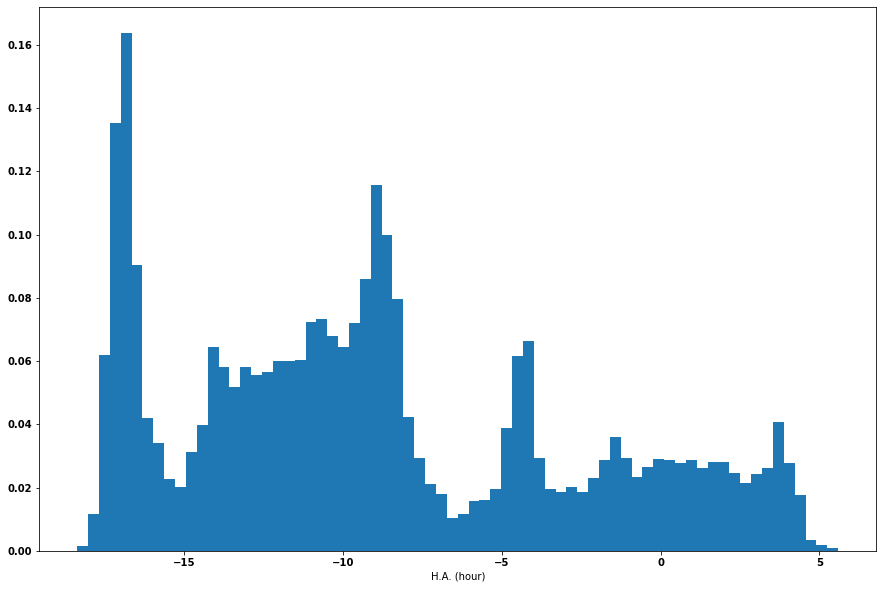

In [9]:
plt.figure(figsize=(15,10))
plt.hist(sky_sci_table["ha"], bins=70, density=True)
plt.xlabel("H.A. (hour)")

In [10]:
mask = np.abs(sky_sci_table["ha"]) <= 3.5
mask &= sky_sci_table["airmass"] < 1.3
mask &= (survey["shadow_height"].min() <= sky_sci_table["shadow_heights"]) & (sky_sci_table["shadow_heights"] <= survey["shadow_height"].max())


sky_sci_match = sky_sci_table[mask]
sky_sci_match

sky_id,sci_id,distance,shadow_heights,alt,az,lst,airmass,lunation,moon_dist,ha
int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,1,15.147776564315736,577.0862009548568,56.248511611666856,44.67622786625379,3.596714188448762,1.2027106502797467,0.7044262657977536,17.203953610893112,-1.5161255337712394
2,1,8.071760139456018,605.1411765600358,52.67443711653688,55.501143760764286,3.596714188448762,1.2575404703951416,0.7044262657977536,16.00194834482011,-1.9875001634045724
3,1,8.054750940158803,602.5108251470051,52.91009008158334,56.036505574570135,3.596714188448762,1.2536196001803215,0.7044262657977536,15.998676620574338,-1.99101334859124
4,1,8.035843092800018,603.2468264753742,52.83983398131141,55.93506578596192,3.596714188448762,1.2547837636144628,0.7044262657977536,15.995938293577984,-1.9916130337712392
5,1,7.952520568131681,604.8322524041831,52.68066323672846,55.82325556582601,3.596714188448762,1.2574362889388617,0.7044262657977536,15.982425608204403,-1.9962232374779054
6,1,7.94789233892828,593.2421416652767,53.68276822644995,58.676781682282495,3.596714188448762,1.2410794357260209,0.7044262657977536,15.940757823712035,-2.023988885624572
7,1,7.6882175132662045,594.8970930126032,53.465293420056504,58.938169438848035,3.596714188448762,1.2445606433950638,0.7044262657977536,15.896878478512312,-2.041844589331239
8,1,7.576543338919186,595.2845976718891,53.39650044233136,59.15946176884317,3.596714188448762,1.2456696521309811,0.7044262657977536,15.87503139998746,-2.0511445522912393
9,1,7.5397777568481175,591.4712278099538,53.638875722798176,60.77546998610261,3.596714188448762,1.2417790311587096,0.7044262657977536,15.816192329232084,-2.080551200437906


Text(0.5, 0, 'H.A. (hourangle)')

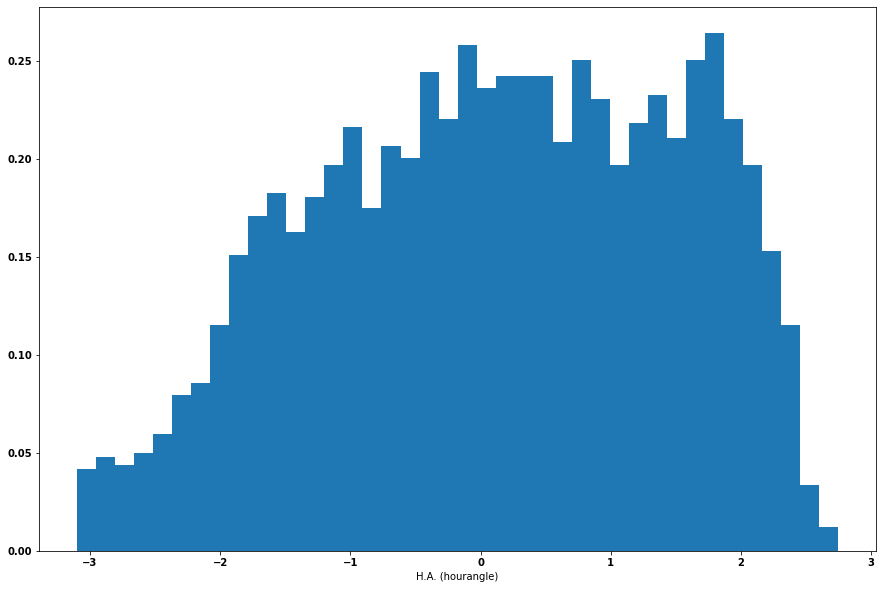

In [11]:
plt.figure(figsize=(15,10))
plt.hist(sky_sci_match["ha"], bins=40, density=True)
plt.xlabel("H.A. (hourangle)")

In [12]:
sky_sci = {}
for idx, row in tqdm(enumerate(survey), total=len(survey), desc="simulating sky for science pointings"):
    date = Time(row["JD"], format="jd") - timedelta(days=5*365)

    _, sky_sci[idx] = sky.get_sky_model(
        wmin=365, wmax=1040, wres=3000,
        observatory="lasilla", date=date.strftime("%Y-%m-%dT%H:%M:%S"),
        ra=row["ra"], dec=row["dec"],
        return_pars=False
    )

simulating sky for science pointings: 100%|██████████| 227/227 [31:43<00:00,  8.39s/it]


In [13]:
sci_i = 5
darks_i = sky_sci_match[sky_sci_match["sci_id"]==sci_i]["sky_id"].value


sky_sky = {}
for idx in tqdm(darks_i, total=len(darks_i), desc="simulating sky for sky pointings"):
    date = Time(survey["JD"][sci_i], format="jd") - timedelta(days=5*365)

    _, sky_sky[idx] = sky.get_sky_model(
        wmin=365, wmax=1040, wres=3000,
        observatory="lasilla", date=date.strftime("%Y-%m-%dT%H:%M:%S"),
        ra=new_darks["ra"][idx], dec=new_darks["dec"][idx],
        return_pars=False
    )

simulating sky for sky pointings: 100%|██████████| 31/31 [04:18<00:00,  8.34s/it]


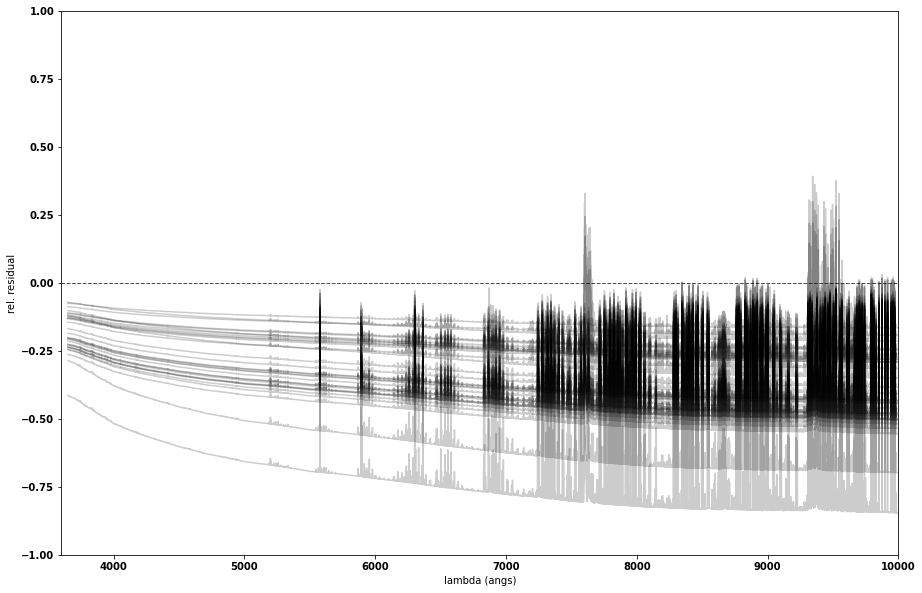

In [14]:
fig, ax = plt.subplots(figsize=(15,10))
ax.set_xlim(3600, 10000)
ax.set_ylim(-1, 1)
ax.set_xlabel(r"lambda (angs)")
ax.set_ylabel(r"rel. residual")

ax.axhline(ls="--", lw=1, color="r")


for idx in sky_sky.keys():
    joint_residuals = (sky_sky[idx]["flux"]-sky_sci[sci_i]["flux"]) / sky_sky[sci_i]["flux"]

    ax.plot(sky_sky[idx]["lam"], joint_residuals, color="k", lw=1.5, alpha=0.2)

In [15]:
# run simulations for sky module as close as possible to the DRP (actual sky module)
# transform simulations to counts
# feed them to the sky module and quantify the effects of interpolation and variability effects
# 